# Projet MNIST

##### Chargement des modules nécéssaires

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt # plots
import os 
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix

##### Chargement des données MNIST

In [3]:
from keras.datasets import fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [6]:
print(np.unique(train_labels))
print(train_images.shape)

[0 1 2 3 4 5 6 7 8 9]
(60000, 28, 28)


Il y a bien 10 labels, et 60 000 images 28x28 dans les données.

##### Visualisation de quelques données 

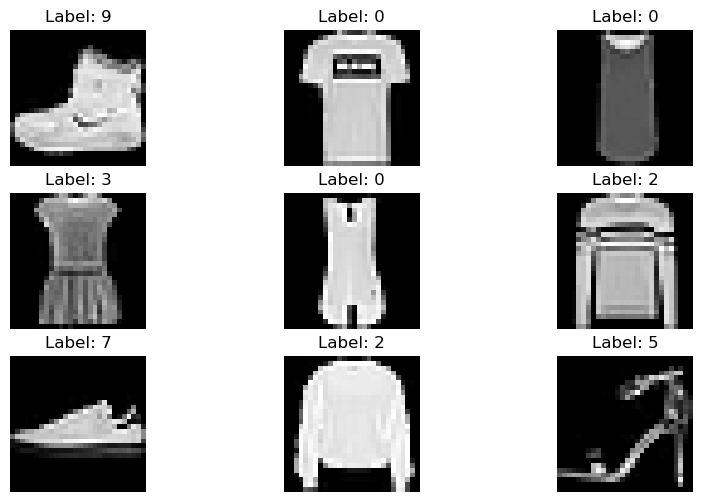

In [12]:
# On va visualiser 9 images
num_rows, num_cols = 3, 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 6))

for i, ax in enumerate(axes.flat): 
    ax.imshow(train_images[i], cmap='gray')  
    ax.set_title(f"Label: {train_labels[i]}")  

    ax.axis('off')  # Masquer les axes

plt.show()


##### Construction d'un réseau de neurones "simple"

On va commencer par "applatir" les images en un vecteur de longeur 784 (28x28)

In [14]:
train_images_flat = train_images.reshape(train_images.shape[0], -1)  
test_images_flat = test_images.reshape(test_images.shape[0], -1)

Ensuite on réalise un one hot encoding sur les labels train et test

In [16]:
y_train_oh = pd.get_dummies(train_labels) # OHE
y_test_oh = pd.get_dummies(test_labels) # OHE

In [18]:
y_train_oh.head()

,0,1,2,3,4,5,6,7,8,9
0,False,False,False,False,False,False,False,False,False,True
1,True,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False
3,False,False,False,True,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False


Maintenant on construit le réseau de neurones simple. . Attention ; on utilise le dropout de 30% pour éviter le surapprentissage. Par exemple, un dropout de 50% signifie que 50% des neurones sont ignorés au cours de chaque itération. Ces neurones sont choisis aléatoirement.

In [71]:
simple_nn = tf.keras.models.Sequential([
    #Sequential : Enchainement des couches de manière séquentielle. Toutes les couches sont reliées les unes aux autres.

    #Couche d'entrée
    tf.keras.layers.Dense(units= train_images_flat.shape[1] , activation='relu', input_shape=(train_images_flat.shape[1],)),

    #Premère couche cachée
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    
    # Seconde couche cachée 
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.3),  
    
    # Couche de sortie
    tf.keras.layers.Dense(units=10, activation="softmax")
])

C:\Users\Rose Tchala Sare\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compilation du modèle :

In [72]:
simple_nn.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                  loss=tf.keras.losses.CategoricalCrossentropy(), #Classification multiclasse
                  metrics=[tf.keras.metrics.CategoricalAccuracy()])


In [73]:
simple_nn.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_74 (Dense)                │ (None, 784)            │       615,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 850,586 (3.24 MB)

 Trainable params: 850,586 (3.24 MB)

 Non-trainable params: 0 (0.00 B)

Entrainement du modèle sur les données train. On utilise l'early stopping pour arrêter l'entrainement lorsque les performances se stabilisent. On choisi le modèle avec les meilleures performances.

In [74]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [75]:
history = simple_nn.fit(train_images_flat, y_train_oh, epochs=20, validation_data=(test_images_flat, y_test_oh), batch_size=100,  callbacks=[early_stopping])

Epoch 1/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - categorical_accuracy: 0.3947 - loss: 13.3417 - val_categorical_accuracy: 0.4129 - val_loss: 1.4917
Epoch 2/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - categorical_accuracy: 0.4012 - loss: 1.9749 - val_categorical_accuracy: 0.4530 - val_loss: 1.3280
Epoch 3/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - categorical_accuracy: 0.4267 - loss: 1.7066 - val_categorical_accuracy: 0.4680 - val_loss: 1.2181
Epoch 4/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - categorical_accuracy: 0.4592 - loss: 1.4412 - val_categorical_accuracy: 0.5748 - val_loss: 1.0957
Epoch 5/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - categorical_accuracy: 0.5520 - loss: 1.2745 - val_categorical_accuracy: 0.6457 - val_loss: 0.8588
Epoch 6/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - categorical_accuracy: 0.5839 - loss: 1.1939 - val_categorical_accuracy: 0.6328 - val_loss: 0.9129
Epoch 7/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - categorical_accuracy: 0.6146 - lo

On va visualiser les performances du modèle :

In [30]:
# Afficher l'accuracy à la dernière époque d'entraînement
train_accuracy = history.history['categorical_accuracy'][-1]
print(f"Accuracy sur l'entraînement à la dernière époque: {train_accuracy}")

#  afficher l'accuracy sur la validation
val_accuracy = history.history['val_categorical_accuracy'][-1]
print(f"Accuracy sur la validation à la dernière époque: {val_accuracy}")

Accuracy sur l'entraînement à la dernière époque: 0.6161333322525024
Accuracy sur la validation à la dernière époque: 0.6998000144958496


dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss'])


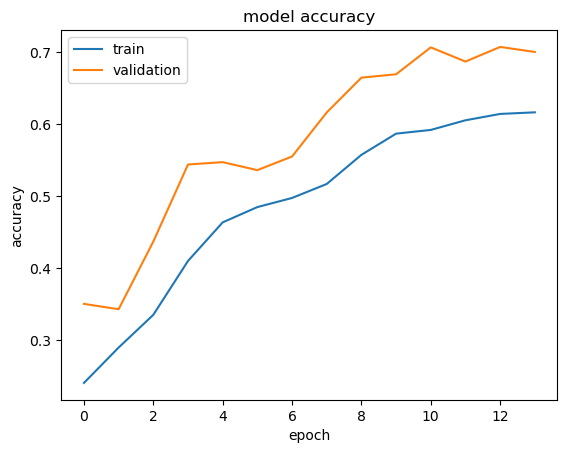

In [25]:
print(history.history.keys())
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

On remarque que les performances du modèle en validation sont meilleures qu'en entrainement.

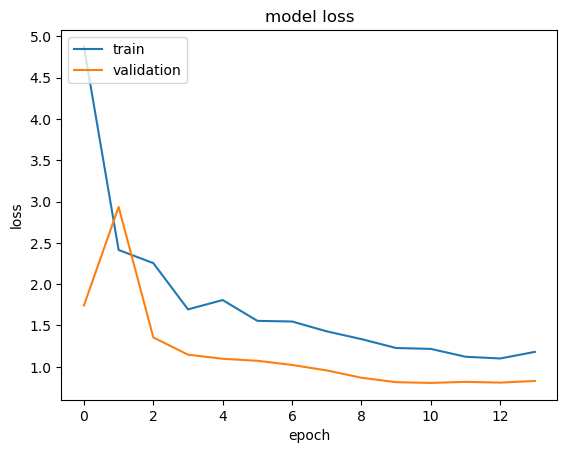

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

On va prédire les données test pour les comparer avec le réseau CNN (voir dernière partie)

In [77]:
pred_Dense = simple_nn.predict(test_images_flat)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


On va effectuer une validation  de notre modèle avec k-fold cross validation pour avoir un point de vue plus robuste de sa performance.

In [31]:
from sklearn.model_selection import KFold

In [35]:
#Création d'une fonction qui retourne un modele :

def create_model():
    simple_nn = tf.keras.models.Sequential([
    #Sequential : Enchainement des couches de manière séquentielle. Toutes les couches sont reliées les unes aux autres.

    #Couche d'entrée
    tf.keras.layers.Dense(units= train_images_flat.shape[1] , activation='relu', input_shape=(train_images_flat.shape[1],)),

    #Premère couche cachée
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    
    # Seconde couche cachée 
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.3),  
    
    # Couche de sortie
    tf.keras.layers.Dense(units=10, activation="softmax")
])
    simple_nn.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                  loss=tf.keras.losses.CategoricalCrossentropy(), #Classification multiclasse
                  metrics=[tf.keras.metrics.CategoricalAccuracy()])

    return simple_nn


In [44]:
from sklearn.model_selection import KFold
import numpy as np

# Paramètres
n_splits = 5  # Nombre de splits dans le K-Fold
epochs = 10  # Nombre d'époques d'entraînement pour chaque fold

# Initialiser KFold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

#On va garder les résultats de chaque fold
fold_no = 1
fold_accuracies = []

# Boucle sur chaque split du KFold
for train_index, val_index in kf.split(train_images_flat):  # Utiliser les données aplaties pour KFold
    
    print(f'Training on fold {fold_no}...')
    
    # Créer le modèle pour ce fold (Supposons que la fonction create_model est définie)
    model = create_model()
    
    # Diviser les données en train et validation pour ce fold
    X_train, X_val = train_images_flat[train_index], train_images_flat[val_index]

    y_train_oh_np = pd.get_dummies(train_labels).values  # .values convertit en Numpy array

    y_train, y_val = y_train_oh_np[train_index], y_train_oh_np[val_index]
    
    # Entraîner le modèle
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val))
    
    # Évaluer la précision sur les données de validation
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    print(f'Fold {fold_no} - Validation Accuracy: {val_acc}')
    
    # Stocker la précision pour ce fold
    fold_accuracies.append(val_acc)
    
    fold_no += 1

# Moyenne des précisions sur les folds
print(f'Average Validation Accuracy: {np.mean(fold_accuracies)}')
print(f'Standard Deviation of accuracy: {np.std(fold_accuracies)}')



Training on fold 1...
Epoch 1/10


C:\Users\Rose Tchala Sare\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - categorical_accuracy: 0.2191 - loss: 11.2107 - val_categorical_accuracy: 0.2898 - val_loss: 1.8335
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - categorical_accuracy: 0.2527 - loss: 2.1834 - val_categorical_accuracy: 0.2998 - val_loss: 1.8003
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - categorical_accuracy: 0.2860 - loss: 2.2614 - val_categorical_accuracy: 0.3153 - val_loss: 1.7454
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - categorical_accuracy: 0.3047 - loss: 2.2405 - val_categorical_accuracy: 0.3433 - val_loss: 1.6875
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - categorical_accuracy: 0.3233 - loss: 2.3226 - val_categorical_accuracy: 0.3742 - val_loss: 1.5779
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - categorical_accuracy: 0.3594 - loss: 2.0534 - val_categorical_accuracy: 0.4507 - val_loss: 1.4468
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - categorical_accuracy: 0.3991 -

En moyenne, le modèle obtient une précision de 62% sur des données de validation non vues. Cependant, entre les folds on remarque une certaine variance (45%-72%). Cela signifique que la performance de notre modèle varie fortement selon les données d'entrainement utilisées. Ce modèle n'est pas vraiment stable.

##### CNN

Pour le premier modèle j'ajoute une seule couche convolutionelle avec 32 filters (pour capture les caractéristiques de bas niveau comme les bords, les textures)

In [48]:
simple_nn = tf.keras.models.Sequential([
    #Sequential : Enchainement des couches de manière séquentielle. Toutes les couches sont reliées les unes aux autres.

    # #Couche d'entrée
    tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),

    #Premère couche convolutionelle
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Applatissement de l'image pour les couches denses
    tf.keras.layers.Flatten(),

    #Premère couche cachée
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    
    # Seconde couche cachée 
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.3),  
    
    # Couche de sortie
    tf.keras.layers.Dense(units=10, activation="softmax")
])

#Compilation du modèle
simple_nn.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                  loss=tf.keras.losses.CategoricalCrossentropy(), #Classification multiclasse
                  metrics=[tf.keras.metrics.CategoricalAccuracy()])


C:\Users\Rose Tchala Sare\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [49]:
simple_nn.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 256)            │     1,384,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,419,210 (5.41 MB)

 Trainable params: 1,419,210 (5.41 MB)

 Non-trainable params: 0 (0.00 B)

Comme on utilise un réseau de neurones convolutionnel, on utiliser les images comme elles sont données dans le jeu de donnée. Il n'y a pas besoin de les applatir puisqu'elles sont traitées directement en tant que matrice 28*28.

In [50]:
history = simple_nn.fit(train_images, y_train_oh, epochs=20, validation_data=(test_images, y_test_oh), batch_size=100,  callbacks=[early_stopping])

Epoch 1/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - categorical_accuracy: 0.6699 - loss: 10.8726 - val_categorical_accuracy: 0.8684 - val_loss: 0.3760
Epoch 2/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - categorical_accuracy: 0.8732 - loss: 0.3637 - val_categorical_accuracy: 0.8797 - val_loss: 0.3570
Epoch 3/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - categorical_accuracy: 0.8927 - loss: 0.3110 - val_categorical_accuracy: 0.8916 - val_loss: 0.3250
Epoch 4/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - categorical_accuracy: 0.9002 - loss: 0.2885 - val_categorical_accuracy: 0.8724 - val_loss: 0.3932
Epoch 5/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - categorical_accuracy: 0.9039 - loss: 0.2786 - val_categorical_accuracy: 0.8896 - val_loss: 0.3662
Epoch 6/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - categorical_accuracy: 0.9071 - loss: 0.2724 - val_categorical_accuracy: 0.8883 - val_loss: 0.3521


dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss'])


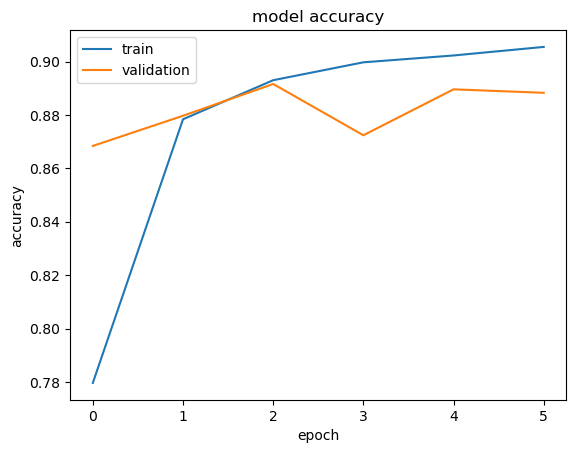

In [51]:
print(history.history.keys())
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

On remarque immédiatement qu'on à de bien meilleures performances en ajoutant à notre modèle une couche convolutionelle (alors que les couches denses restent identiques). En effet, on obtient en validation 88% de bonnes réponses contre 69% avec le réseau simple
Grâce au early stopping on remarque que le modèle s'est stabilisé beaucoup plus rapidement (5 epochs avec le CNN contre 14 pour le réseau simple).

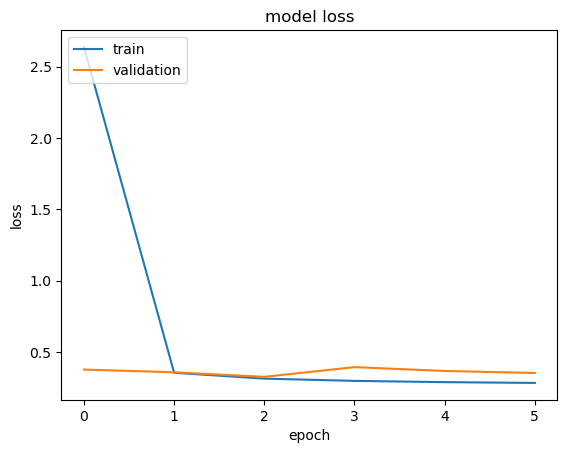

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

On va évaluer la performance du modèle CNN avec un K fold cross validation.

In [55]:
#Création d'une fonction qui retourne un modele :

def create_model():
    simple_nn = tf.keras.models.Sequential([
    #Sequential : Enchainement des couches de manière séquentielle. Toutes les couches sont reliées les unes aux autres.

    # #Couche d'entrée
    tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),

    #Premère couche convolutionelle
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Applatissement de l'image pour les couches denses
    tf.keras.layers.Flatten(),

    #Premère couche cachée
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    
    # Seconde couche cachée 
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.3),  
    
    # Couche de sortie
    tf.keras.layers.Dense(units=10, activation="softmax")
])

    #Compilation du modèle
    simple_nn.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                  loss=tf.keras.losses.CategoricalCrossentropy(), #Classification multiclasse
                  metrics=[tf.keras.metrics.CategoricalAccuracy()])

    return simple_nn


In [57]:
# Paramètres
n_splits = 5  # Nombre de splits dans le K-Fold
epochs = 10  # Nombre d'époques d'entraînement pour chaque fold

# Initialiser KFold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

#On va garder les résultats de chaque fold
fold_no = 1
fold_accuracies = []

# Boucle sur chaque split du KFold
for train_index, val_index in kf.split(train_images):  # Utiliser les données aplaties pour KFold
    
    print(f'Training on fold {fold_no}...')
    
    # Créer le modèle pour ce fold (Supposons que la fonction create_model est définie)
    model = create_model()
    
    # Diviser les données en train et validation pour ce fold
    X_train, X_val = train_images[train_index], train_images[val_index]

    y_train_oh_np = pd.get_dummies(train_labels).values  # .values convertit en Numpy array

    y_train, y_val = y_train_oh_np[train_index], y_train_oh_np[val_index]
    
    # Entraîner le modèle
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=0)
    
    # Évaluer la précision sur les données de validation
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    print(f'Fold {fold_no} - Validation Accuracy: {val_acc}')
    
    # Stocker la précision pour ce fold
    fold_accuracies.append(val_acc)
    
    fold_no += 1

# Moyenne des précisions sur les folds
print(f'Average Validation Accuracy: {np.mean(fold_accuracies)}')
print(f'Standard Deviation of accuracy: {np.std(fold_accuracies)}')

Training on fold 1...
Fold 1 - Validation Accuracy: 0.8474166393280029
Training on fold 2...
Fold 2 - Validation Accuracy: 0.8479999899864197
Training on fold 3...
Fold 3 - Validation Accuracy: 0.8551666736602783
Training on fold 4...
Fold 4 - Validation Accuracy: 0.8452500104904175
Training on fold 5...
Fold 5 - Validation Accuracy: 0.8448333144187927
Average Validation Accuracy: 0.8481333255767822
Standard Deviation of accuracy: 0.0037202952128178915


On remarque tout de suite que les performances moyennes sont très bonnes en validation, et entre les folds, la variance est faible. Ce modèle est bon.

##### Comparaison de la classification. Variation des paramètres du modèle

Je vais essayer d'ajouter deux autres couches convolutionelles (filter 64 et 128) pour récupérer des détails plus précis sur chaque image. De plus, je vais changer la fonction d'activation et utiliser Adam.

In [64]:
simple_nn = tf.keras.models.Sequential([
    #Sequential : Enchainement des couches de manière séquentielle. Toutes les couches sont reliées les unes aux autres.

    # #Couche d'entrée
    tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),

    #Premère couche convolutionelle
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Seconde couche convolutionelle
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Troisième couche convolutionelle
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Applatissement de l'image pour les couches denses
    tf.keras.layers.Flatten(),

    #Premère couche cachée
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    
    # Seconde couche cachée 
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.3),  
    
    # Couche de sortie
    tf.keras.layers.Dense(units=10, activation="softmax")
])

C:\Users\Rose Tchala Sare\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [65]:
# Compilation du modèle
simple_nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Remplacer RMSprop par Adam
                  loss=tf.keras.losses.CategoricalCrossentropy(),  # Classification multiclasse
                  metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [66]:
simple_nn.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,882 (624.54 KB)

 Trainable params: 159,882 (624.54 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
history = simple_nn.fit(train_images, y_train_oh, epochs=10, validation_data=(test_images, y_test_oh), batch_size=100)

Epoch 1/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - categorical_accuracy: 0.6376 - loss: 1.3697 - val_categorical_accuracy: 0.8302 - val_loss: 0.4657
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - categorical_accuracy: 0.8378 - loss: 0.4563 - val_categorical_accuracy: 0.8458 - val_loss: 0.4198
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - categorical_accuracy: 0.8578 - loss: 0.3949 - val_categorical_accuracy: 0.8575 - val_loss: 0.3860
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - categorical_accuracy: 0.8694 - loss: 0.3541 - val_categorical_accuracy: 0.8666 - val_loss: 0.3657
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - categorical_accuracy: 0.8810 - loss: 0.3261 - val_categorical_accuracy: 0.8698 - val_loss: 0.3595
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - categorical_accuracy: 0.8897 - loss: 0.3027 - val_categorical_accuracy: 0.8725 - val_loss: 0.3615
Epoch 7/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - categorical_accuracy: 

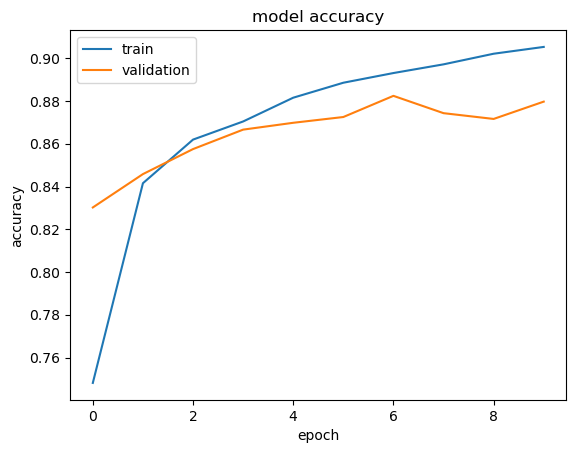

In [68]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

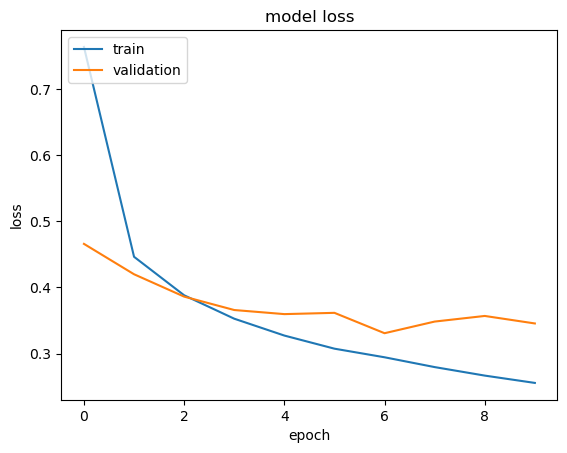

In [69]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

On n'observe pas réellement de différence avec le modèle précédent en changeant les paramètres. Les performances sont toujours aussi bonnes (87% de bonnes réponses en validation).

In [70]:
pred_CNN =simple_nn.predict(test_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


#### Comparaison statistiques des résultats entre le réseau sur les données test

L'objectif de cette partie est de déterminer si il y a une différence statistique entre la répartition des classes selon nos deux modèles, le modèle utilisant un réseau formé uniquement de couches denses, et notre dernier modèle utilisant trois couches convolutionelles.

Le protocole utilisé est simple. Pour chaque modèle, nous allons contabiliser l'occurence de chaque classe dans un vecteur et assembler les deux vecteurs dans une table de contingence. Comme nos prédictions sont des valeurs catégoriques, il serait erroné de faire un t-test. Nous allons donc faire un test du Chi-2 et regarder s'il y a une différence significative dans la répartition des classes entre les deux vecteurs.

In [80]:
#Les vecteurs pred CNN et pred Dense contiennent des probabilités. On doit récuperer pour chaque élement la classe la plus probable.
classes_CNN = np.argmax(pred_CNN, axis=1)
classes_Dense = np.argmax(pred_Dense, axis=1)

In [99]:
#On crée un vecteur avec les occurences de chaque classe
occ_CNN = np.unique(classes_CNN, return_counts=True)
occ_Dense = np.unique(classes_Dense, return_counts=True)

<BarContainer object of 10 artists>

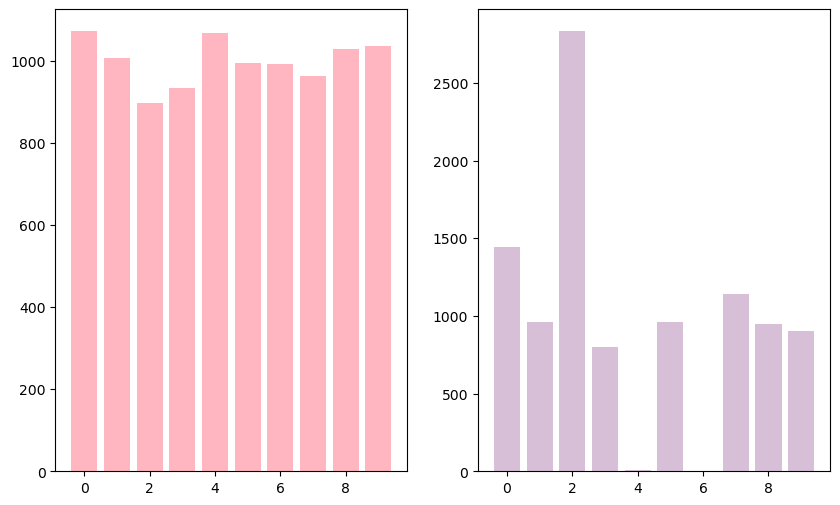

In [104]:
#On va visualiser les occurences dans un barplot
# On va visualiser 9 images

num_rows, num_cols = 1, 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 6))

#vecteur contenant le label de chaque classe
classe = np.array([i for i in range(0, 10)])

ax = axes.flat[0]
ax.bar(classe, occ_CNN[1], color='lightpink')

ax = axes.flat[1]
ax.bar(classe, occ_Dense[1], color='thistle')




La répartition des classes entre le réseau Convolutionnel (Rose) et le réseau Dense (violet) est très très différente. Confirmons tout cela avec un test du chi-deux.

In [108]:
from scipy.stats import chi2_contingency

data = np.array([occ_CNN[1], occ_Dense[1]]).T

# Effectuer le test du chi-deux
chi2_stat, p_value, dof, expected = chi2_contingency(data)

# Afficher les résultats
print(f"Statistique du chi-deux: {chi2_stat}")
print(f"Valeur p: {p_value}")
print(f"Degrés de liberté: {dof}")

Statistique du chi-deux: 3124.600251245699
Valeur p: 0.0
Degrés de liberté: 9


Comment attendu, il y a une différence signnificative entre la répartition des classes pour les données test. On peut conclure que statistiquement les performances des deux types de structures diffèrent en terme de performance.